In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
class GreekLettersDataset(Dataset):
    def __init__(self, x_path, t_path, transform=None):
        self.x = pd.read_csv(x_path, header=None).values.astype(np.float32)
        self.t = pd.read_csv(t_path, header=None).values.flatten().astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        img = self.x[idx].reshape(100, 100).astype(np.float32)
        img = np.stack([img]*3, axis=0)
        if self.transform:
            img = self.transform(torch.tensor(img))
        else:
            img = torch.tensor(img, dtype=torch.float32) / 255.0
        label = self.t[idx]
        return img, label

In [5]:
def test(x_path, t_path, display_images=5):
    # Mapping from integer labels to Greek letter names
    label_to_letter = {
        0: "alpha",
        1: "beta",
        2: "gamma",
        3: "delta",
        4: "epsilon",
        5: "eta",
        6: "theta",
        7: "lambda",
        8: "mu",
        9: "pi"
    }

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    dataset = GreekLettersDataset(x_path, t_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Load the trained model
    model = models.resnet18(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 10)
    model.load_state_dict(torch.load('greek_model.pt'))  # Load the saved model
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    incorrect_preds = []  # Store incorrect predictions
    incorrect_images = []  # Store corresponding images
    incorrect_labels = []  # Store true labels
    incorrect_predictions = []  # Store predicted labels

    # Evaluate the model
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Collect incorrect predictions
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    incorrect_preds.append(preds[i].item())
                    incorrect_images.append(imgs[i].cpu().numpy())
                    incorrect_labels.append(labels[i].item())
                    incorrect_predictions.append(preds[i].item())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Visualize incorrect predictions
    num_incorrect = min(display_images, len(incorrect_images))
    if num_incorrect > 0:
        print(f"\nVisualizing {num_incorrect} incorrect predictions:")

        # Dynamically calculate rows and columns for the figure
        cols = 5  # Number of images per row
        rows = (num_incorrect + cols - 1) // cols  # Calculate the number of rows needed

        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten()  # Flatten the axes array for easy indexing

        for i in range(num_incorrect):
            img = incorrect_images[i].transpose(1, 2, 0)[:, :, 0]  # Convert to grayscale
            true_letter = label_to_letter[incorrect_labels[i]]
            pred_letter = label_to_letter[incorrect_predictions[i]]
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"True: {true_letter}\nPred: {pred_letter}")
            axes[i].axis('off')

        # Hide any unused subplots
        for i in range(num_incorrect, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No incorrect predictions to visualize.")

    return accuracy, incorrect_preds

Test Accuracy: 0.9458

Visualizing 20 incorrect predictions:


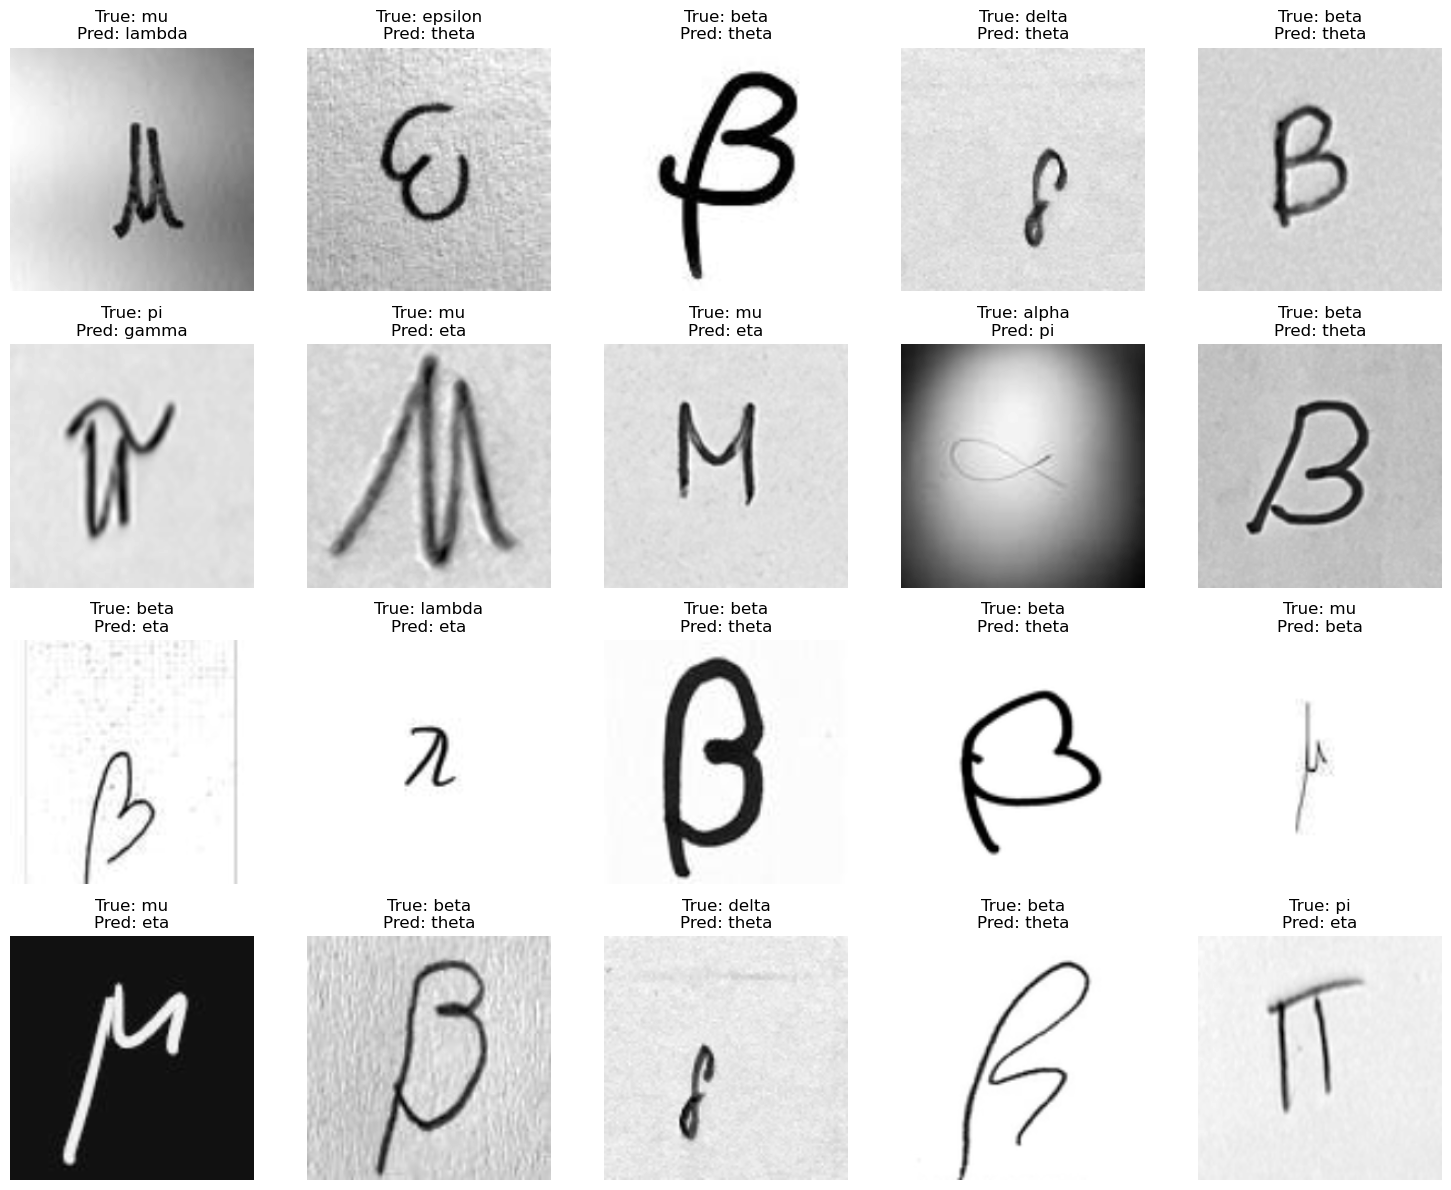

In [6]:
accuracy, incorrect_predictions = test('../data/x_test_split.csv', '../data/t_test_split.csv', 20)